In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import hvplot.pandas
from pathlib import Path
from pandas_datareader import DataReader
import pandas_datareader.data as web
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import quandl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Setting dates
start = datetime.datetime(2016, 12, 1)
end = datetime.datetime.now()

In [3]:
# importing TSLA / BABA / AMD / SQ
amd_df = DataReader('AMD', 'yahoo', start, end)
amd_close = amd_df[['Close', 'Volume']]
amd_close.columns = ['AMD_Close', 'AMD_Volume']
amd_close.head(5)

,AMD_Close,AMD_Volume
Date,,
2016-12-01,8.39,56682400
2016-12-02,8.53,42398900
2016-12-05,8.68,31410100
2016-12-06,9.45,92242900
2016-12-07,9.56,54897300


In [4]:
mu_df = DataReader('MU', 'yahoo', start, end)
mu_close = mu_df[['Close', 'Volume']]
mu_close.columns = ['MU_Close', 'MU_Volume']
mu_close.head(5)

,MU_Close,MU_Volume
Date,,
2016-12-01,18.480000,40713100
2016-12-02,18.790001,25887600
2016-12-05,18.610001,26635500
2016-12-06,19.059999,22267800
2016-12-07,20.440001,44735700


In [5]:
nvda_df = DataReader('NVDA', 'yahoo', start, end)
nvda_close = nvda_df[['Close', 'Volume']]
nvda_close.columns = ['NVDA_Close', 'NVDA_Volume']
nvda_close.head(5)

,NVDA_Close,NVDA_Volume
Date,,
2016-12-01,87.639999,25888100.0
2016-12-02,88.449997,11957300.0
2016-12-05,91.879997,15057100.0
2016-12-06,93.389999,12469900.0
2016-12-07,95.070000,12020100.0


In [12]:
intc_df = DataReader('INTC', 'yahoo', start, end)
intc_close = intc_df[['Close', 'Volume']]
intc_close.columns = ['INTC_Close', 'INTC_Volume']
intc_close.head(5)

,INTC_Close,INTC_Volume
Date,,
2016-12-01,33.759998,29618700.0
2016-12-02,34.160000,21492500.0
2016-12-05,34.389999,14462000.0
2016-12-06,34.720001,15297700.0
2016-12-07,35.500000,21710300.0


# Features

In [30]:


# ADI (Analog Devices / Semiconductor-Integrated circuits)
adi_df = DataReader('ADI', 'yahoo', start, end)
adi_close = adi_df[['Close', 'Volume']]
adi_close.columns = ['ADI_Close', 'ADI_Volume']

# XLNX (Xilixn.Inc / Supplier of programmable logic devices)
xlnx_df = DataReader('XLNX', 'yahoo', start, end)
xlnx_close = xlnx_df[['Close', 'Volume']]
xlnx_close.columns = ['XLNX_Close', 'XLNX_Volume']

# MCHI
mchi_df = DataReader('MCHI', 'yahoo', start, end)
mchi_close = mchi_df[['Close', 'Volume']]
mchi_close.columns = ['MCHI_Close', 'MCHI_Volume']

# AMAT (Applied Materials)
amat_df = DataReader('AMAT', 'yahoo', start, end)
amat_close = amat_df[['Close', 'Volume']]
amat_close.columns = ['AMAT_Close', 'AMAT_Volume']

# ASML (ASML Holdings / Silicon Supplier)
asml_df = DataReader('ASML', 'yahoo', start, end)
asml_close = asml_df[['Close', 'Volume']]
asml_close.columns = ['ASML_Close', 'ASML_Volume']

# LRCX (Lam Research)
lrcx_df = DataReader('LRCX', 'yahoo', start, end)
lrcx_close = lrcx_df[['Close', 'Volume']]
lrcx_close.columns = ['LRCX_Close', 'LRCX_Volume']

# SLAB (Silicon Labs)
slab_df = DataReader('SLAB', 'yahoo', start, end)
slab_close = slab_df[['Close', 'Volume']]
slab_close.columns = ['SLAB_Close', 'SLAB_Volume']

# KLAC (KLA Corporation)
klac_df = DataReader('KLAC', 'yahoo', start, end)
klac_close = klac_df[['Close', 'Volume']]
klac_close.columns = ['KLAC_Close', 'KLAC_Volume']

In [14]:
# Concatenating each stock
stocks_df = pd.concat([amd_close, mu_close, nvda_close, intc_close, adi_close, xlnx_close, mchi_close, amat_close, asml_close, lrcx_close, slab_close, klac_close], axis=1, join='outer')
stocks_df.isnull().sum()

AMD_Close      0
AMD_Volume     0
MU_Close       0
MU_Volume      0
NVDA_Close     0
NVDA_Volume    0
INTC_Close     0
INTC_Volume    0
ADI_Close      0
ADI_Volume     0
XLNX_Close     0
XLNX_Volume    0
MCHI_Close     0
MCHI_Volume    0
AMAT_Close     0
AMAT_Volume    0
ASML_Close     0
ASML_Volume    0
LRCX_Close     0
LRCX_Volume    0
SLAB_Close     0
SLAB_Volume    0
KLAC_Close     0
KLAC_Volume    0
dtype: int64

# Correlation 

In [29]:
import seaborn as sns
daily_returns = stocks_df.pct_change()
daily_returns = daily_returns.dropna()
daily_returns.columns

Index(['AMD_Close', 'AMD_Volume', 'MU_Close', 'MU_Volume', 'NVDA_Close',
       'NVDA_Volume', 'INTC_Close', 'INTC_Volume', 'ADI_Close', 'ADI_Volume',
       'XLNX_Close', 'XLNX_Volume', 'MCHI_Close', 'MCHI_Volume', 'AMAT_Close',
       'AMAT_Volume', 'ASML_Close', 'ASML_Volume', 'LRCX_Close', 'LRCX_Volume',
       'SLAB_Close', 'SLAB_Volume', 'KLAC_Close', 'KLAC_Volume'],
      dtype='object')

NVDA_Close     1.000000
AMAT_Close     0.579924
MU_Close       0.565795
ASML_Close     0.563943
AMD_Close      0.556355
ADI_Close      0.554654
KLAC_Close     0.541218
LRCX_Close     0.534971
SLAB_Close     0.518765
MCHI_Close     0.506701
XLNX_Close     0.506607
INTC_Close     0.497561
AMAT_Volume    0.114615
KLAC_Volume    0.055514
NVDA_Volume    0.052865
ADI_Volume     0.040612
INTC_Volume    0.037505
AMD_Volume     0.035612
MCHI_Volume    0.034806
MU_Volume      0.027045
ASML_Volume    0.017467
LRCX_Volume    0.010804
XLNX_Volume    0.002809
SLAB_Volume    0.000833
Name: NVDA_Close, dtype: float64

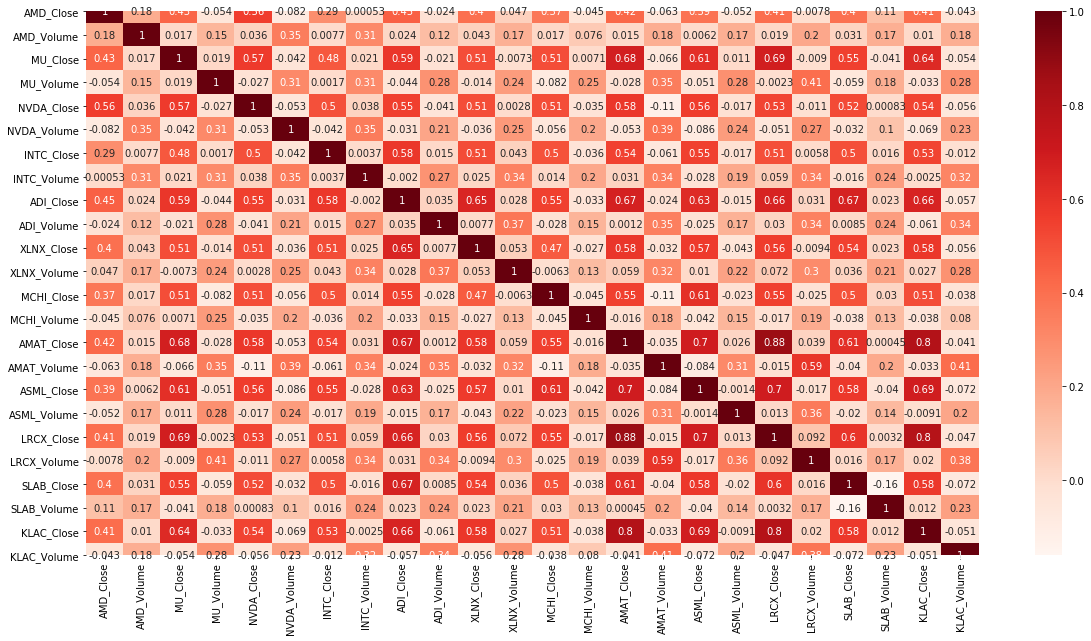

In [16]:
correlation = daily_returns.corr()

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
cor_target = abs(correlation['NVDA_Close'])

#Selecting highly correlated features
re_features = cor_target[cor_target>0.0]
re_features.sort_values(ascending=False)

# Volatility

In [25]:
#Augmented Dickey-Fuller test to determine if the stocks are stationary
from statsmodels.tsa.stattools import adfuller
adfuller(stocks_df.NVDA_Close)

(-0.8672184416155333,
 0.7985761251023932,
 12,
 1256,
 {'1%': -3.4355671297788666,
  '5%': -2.8638438984080117,
  '10%': -2.5679966213893057},
 6969.706182123341)

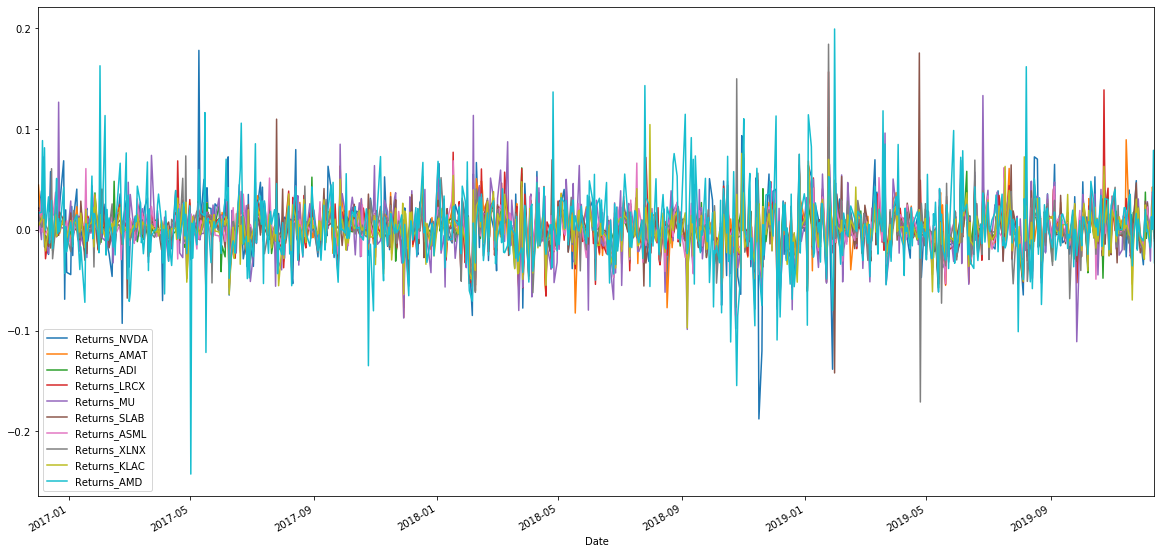

In [28]:
# Making stationary
df = stocks_df.copy()
df['Returns_NVDA'] = df.NVDA_Close.pct_change()
df['Returns_AMAT'] = df.AMAT_Close.pct_change()
df['Returns_ADI'] = df.ADI_Close.pct_change()
df['Returns_LRCX'] = df.LRCX_Close.pct_change()
df['Returns_MU'] = df['MU_Close'].pct_change() 
df['Returns_SLAB'] = df['SLAB_Close'].pct_change() 
df['Returns_ASML'] = df['ASML_Close'].pct_change() 
df['Returns_XLNX'] = df['XLNX_Close'].pct_change()
df['Returns_KLAC'] = df['KLAC_Close'].pct_change() 
df['Returns_AMD'] = df['AMD_Close'].pct_change() 


df = df.dropna()

# Organize
returns_nvda = df.loc[:, 'Returns_NVDA']
returns_amat = df.loc[:, 'Returns_AMAT']
returns_adi = df.loc[:, 'Returns_ADI']
returns_lrcx = df.loc[:, 'Returns_LRCX']
returns_mu = df.loc[:, 'Returns_MU']
returns_slab = df.loc[:, 'Returns_SLAB']
returns_asml = df.loc[:, 'Returns_ASML']
returns_xlnx = df.loc[:, 'Returns_XLNX']
returns_klac = df.loc[:, 'Returns_KLAC']
returns_amd = df.loc[:, 'Returns_AMD']




# Plot the returns
returns_nvda.plot(legend=True, figsize=(20,10))
returns_amat.plot(legend=True)
returns_adi.plot(legend=True)
returns_lrcx.plot(legend=True)
returns_mu.plot(legend=True)
returns_slab.plot(legend=True)
returns_asml.plot(legend=True)
returns_xlnx.plot(legend=True)
returns_klac.plot(legend=True)
returns_amd.plot(legend=True)

In [27]:
# GARCH
import arch as arch
from arch import arch_model

In [28]:
model_nvda = arch_model(returns_nvda, mean='Zero', vol='GARCH', p=2, q=2)
final_nvda = model_nvda.fit(disp='off')
final_nvda.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:           Returns_NVDA   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1967.25
Distribution:                  Normal   AIC:                          -3924.50
Method:            Maximum Likelihood   BIC:                          -3900.46
                                        No. Observations:                  904
Date:                Fri, Dec 13 2019   Df Residuals:                      899
Time:                        12:33:15   Df Model:                            5
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.3373e-04  7.725e-05      3.025  2.483e-03 [8.231e-05,3.851e-04]
alpha[1]       0.0699  6.096e-02      1.147      0.251  [-4.958e-02,  0.189]
alpha[2]       0.3057      0.199      1.537      0.124  [-8.404e-02,  0.695]
beta[1]        0.0000      0.524      0.000      1.000     [ -1.026,  1.026]
beta[2]        0.4123      0.333      1.237      0.216     [ -0.241,  1.065]
============================================================================

Covariance estimator: robust
"""

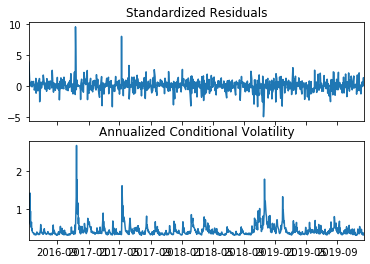

In [29]:
figure_nvda = final_nvda.plot(annualize='D')

In [30]:
# Forecasting from GARCH
last_day = df.index.max().strftime('%Y-%m-%d')
print(last_day)

forecast_horizon = 10
forecasts_nvda = final_nvda.forecast(start=last_day, horizon=forecast_horizon)

# Annualize the forecast
intermediate = np.sqrt(forecasts_nvda.variance.dropna() * 252)
intermediate.head()

2019-12-13


,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
Date,,,,,,,,,,
2019-12-13,0.431221,0.360347,0.448867,0.407689,0.463867,0.439627,0.476334,0.462083,0.486544,0.478274


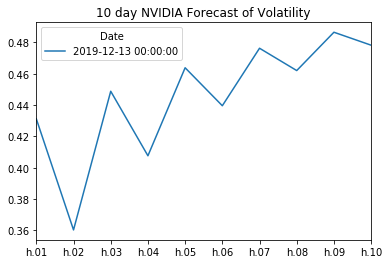

In [31]:
# Plot the forecast
final_nvda_plot = intermediate.dropna().T
final_nvda_plot.plot(title = '10 day NVIDIA Forecast of Volatility')

# Time Series Linear Regression

In [21]:
# Price Prediction 
df_1 = stocks_df.copy()
df_1['Return_nvda'] = df_1['NVDA_Close'].pct_change() * 100
df_1['Return_amat'] = df_1['AMAT_Close'].pct_change() * 100
df_1['Return_adi'] = df_1['ADI_Close'].pct_change() * 100
df_1['Return_lrcx'] = df_1['LRCX_Close'].pct_change() * 100
df_1['Return_mu'] = df_1['MU_Close'].pct_change() * 100
df_1['Return_slab'] = df_1['SLAB_Close'].pct_change() * 100
df_1['Return_asml'] = df_1['ASML_Close'].pct_change() * 100
df_1['Return_xlnx'] = df_1['XLNX_Close'].pct_change() * 100
df_1['Return_klac'] = df_1['KLAC_Close'].pct_change() * 100
df_1['Return_amd'] = df_1['AMD_Close'].pct_change() * 100


df_1 = df_1.dropna()
df_1.head()

#Spliting target and features for dependant and independant variables
y = df_1['Return_nvda']
X = df_1[['Return_amat', 'Return_adi', 'Return_lrcx', 'Return_mu', 'Return_slab', 'Return_asml', 'Return_xlnx', 'Return_klac', 'Return_amd']]
X['Week_of_year'] = X.index.weekofyear
X_binary_encoded = pd.get_dummies(X, columns=['Week_of_year'])

model_linear = LinearRegression()
model_linear.fit(X_binary_encoded, y)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
predictions = model_linear.predict(X_binary_encoded)

r2 = r2_score(y, predictions)
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)

print(f"R-squared (R2): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Standard Deviation of Futures Return: {np.std(y)}")

R-squared (R2): 0.5504395003534046
Mean Squared Error (MSE): 3.4618415170723913
Root Mean Squared Error (RMSE): 1.860602460783171
Standard Deviation of Futures Return: 2.7749778339108406


# Train Test Split Prediction

Out-of-sample Root Mean Squared Error (RMSE): 1.6595047689767373
In-sample Root Mean Squared Error (RMSE): 1.9495368377863935


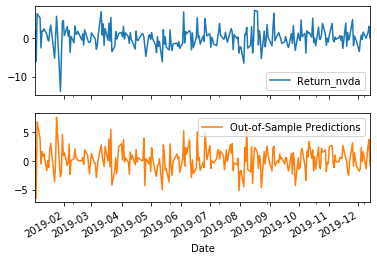

In [34]:
# Train Test Split Predictions
train = df_1.loc['2016':'2019']
test = df_1['2019']

# Create train and test sets for dependent and independent variables
X_train = train[['Return_amat', 'Return_adi', 'Return_lrcx', 'Return_mu', 'Return_slab', 'Return_xlnx', 'Return_klac', 'Return_amd']]
y_train = train["Return_nvda"]
X_test = test[['Return_amat', 'Return_adi', 'Return_lrcx', 'Return_mu', 'Return_slab', 'Return_xlnx', 'Return_klac', 'Return_amd']]
y_test = test["Return_nvda"]


model_nvda = LinearRegression()
model_nvda.fit(X_train, y_train)
predictions = model_nvda.predict(X_test)

out_of_sample_results = y_test.to_frame()
out_of_sample_results["Out-of-Sample Predictions"] = model_nvda.predict(X_test)


#Out-of-Sample
# Plot the out-of-sample results for 2019
out_of_sample_results.plot(subplots=True)

# Calculate out-of-sample mean_squared_error 
out_of_sample_mse = mean_squared_error(out_of_sample_results["Return_nvda"], out_of_sample_results["Out-of-Sample Predictions"])


#In sample
# using just the "y" training data:
in_sample_results = y_train.to_frame()  
in_sample_results["In-sample Predictions"] = model_nvda.predict(X_train)
in_sample_mse = mean_squared_error(in_sample_results["Return_nvda"],in_sample_results["In-sample Predictions"])

# Calculate in-sample / out-of-sample root mean_squared_error
in_sample_rmse = np.sqrt(in_sample_mse)
out_of_sample_rmse = np.sqrt(out_of_sample_mse)
print(f"Out-of-sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}") 

# Deep Learning

In [37]:
# Setting up the dataframe with the closing prices
df_2 = stocks_df.copy()
df_2 = df_2[['NVDA_Close', 'AMAT_Close', 'ADI_Close', 'LRCX_Close', 'MU_Close', 'SLAB_Close', 'ASML_Close', 'XLNX_Close', 'KLAC_Close', 'AMD_Close']]
df_2.head()

,NVDA_Close,AMAT_Close,ADI_Close,LRCX_Close,MU_Close,SLAB_Close,ASML_Close,XLNX_Close,KLAC_Close,AMD_Close
Date,,,,,,,,,,
2016-12-01,87.639999,30.100000,69.010002,98.580002,18.480000,62.250000,99.989998,53.389999,75.930000,8.39
2016-12-02,88.449997,31.440001,70.110001,100.489998,18.790001,63.599998,99.779999,54.220001,76.260002,8.53
2016-12-05,91.879997,31.530001,70.599998,102.400002,18.610001,64.900002,102.919998,54.369999,77.029999,8.68
2016-12-06,93.389999,31.610001,71.000000,103.050003,19.059999,66.250000,102.709999,54.540001,78.120003,9.45
2016-12-07,95.070000,32.509998,72.940002,106.550003,20.440001,67.050003,103.550003,55.299999,79.260002,9.56


In [39]:
# Create the features X and target Y
X = df_2.iloc[:, 0:9].values
y = df_2['NVDA_Close'].values

In [ ]:
# Shallow neural net
nn = Sequential()

number_input_features = 9
number_hidden_nodes = 5

# Hidden
nn.add(Dense(units=number_hidden_nodes,  input_dim=number_input_features, activation='relu'))

# Output
nn.add(Dense(units=1, activation='linear'))

# Compile
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Train the model
model_1 = nn.fit(X, y, validation_split=0.3, epochs=100)

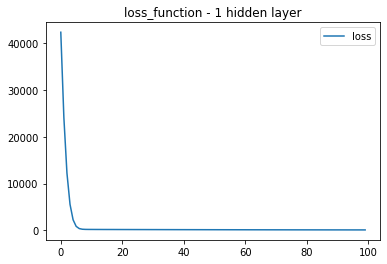

In [43]:
# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.title("loss_function - 1 hidden layer")
plt.legend(["loss"])
plt.show()

In [54]:
# Deep neural net
number_input_features = 9
hidden_nodes_layer1 = 5
hidden_nodes_layer2 = 2

nn = Sequential()

# First hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(Dense(units=1, activation="linear"))

# Compile
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"], activation='sigmoid')

# Fit the model
model_2 = nn.fit(X, y, validation_split=0.3, epochs=100)

Train on 534 samples, validate on 230 samples
Epoch 1/100
534/534 [==============================] - 1s 1ms/sample - loss: 24826.1735 - mse: 24826.1719 - val_loss: 19208.4967 - val_mse: 19208.4961
Epoch 2/100
534/534 [==============================] - 0s 64us/sample - loss: 22400.4171 - mse: 22400.4180 - val_loss: 16769.7498 - val_mse: 16769.7500
Epoch 3/100
534/534 [==============================] - 0s 71us/sample - loss: 19895.5930 - mse: 19895.5918 - val_loss: 14237.7781 - val_mse: 14237.7773
Epoch 4/100
534/534 [==============================] - 0s 78us/sample - loss: 17293.8113 - mse: 17293.8086 - val_loss: 11706.2737 - val_mse: 11706.2734
Epoch 5/100
534/534 [==============================] - 0s 75us/sample - loss: 14673.3688 - mse: 14673.3691 - val_loss: 9241.8073 - val_mse: 9241.8076
Epoch 6/100
534/534 [==============================] - 0s 72us/sample - loss: 12096.4380 - mse: 12096.4375 - val_loss: 6929.8265 - val_mse: 6929.8271
Epoch 7/100
534/534 [==========================

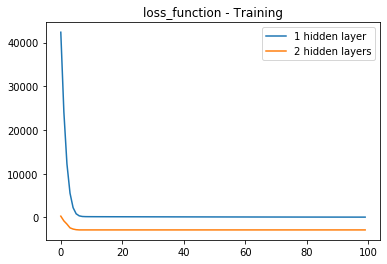

In [51]:
# Plot the train and test loss function
plt.plot(model_1.history["loss"])
plt.plot(model_2.history["loss"])
plt.title("loss_function - Training")
plt.legend(["1 hidden layer", "2 hidden layers"])
plt.show()

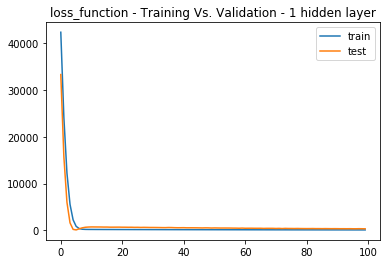

In [52]:
 # Train vs test for shallow net
plt.plot(model_1.history["loss"])
plt.plot(model_1.history["val_loss"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
plt.legend(["train", "test"])
plt.show()

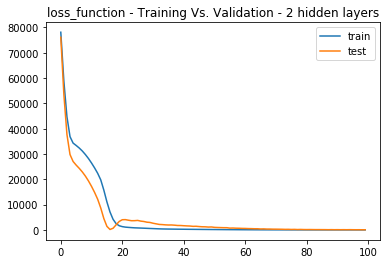

In [47]:
# Train vs test for deep net
plt.plot(model_2.history["loss"])
plt.plot(model_2.history["val_loss"])
plt.title("loss_function - Training Vs. Validation - 2 hidden layers")
plt.legend(["train", "test"])
plt.show()

In [78]:
# With Sklearn (After training)
X = df_2.iloc[:, 0:9].values
y_1 = df_2['NVDA_Close'].values.reshape(-1, 1)

# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y_1[: split - 1]
y_test = y_1[split:]

In [79]:
# Scale / Transform
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y_1)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [99]:
# Reshape the features
X_train_re = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test_re = X_test.reshape(X_test.shape[0], X_train.shape[1], -1)

In [100]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 10
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 10)             480       
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

In [101]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)
model.evaluate(X_test, y_test)

ValueError: Error when checking input: expected lstm_7_input to have 3 dimensions, but got array with shape (4797, 1)

In [ ]:
# Prediction
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

stocks = pd.DataFrame({"Real": real_prices.ravel(), "Predicted": predicted_prices.ravel()})